# Logistic Clasification

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
import torch
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("ex/features.csv")
data.head()

,sex,amp,peak,n170,de
0,f,3.976976,1.396650,3.518662,-4.641687
1,f,2.838296,-2.903568,-1.997229,-4.701930
2,f,-1.428451,-2.606083,0.109957,-4.652843
3,f,-3.363337,3.906902,7.463065,-4.681531
4,f,0.229698,0.727408,2.955038,-4.733215


<AxesSubplot:xlabel='n170', ylabel='de'>

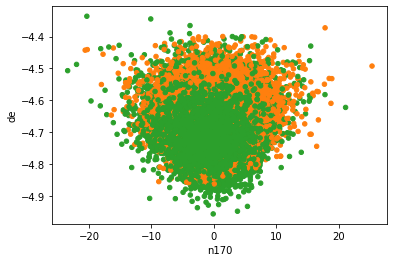

In [3]:
data["color"] = (data["sex"] == "f").apply(lambda x: "C1" if x else "C2")
data.plot.scatter("n170", "de", c="color")

The features don't seem to be linearly separable, so a high accuracy is not expected.

This scikit-learn model expects a features matrix and a labels vector.

In [4]:
X = data[["amp", "peak", "n170", "de"]]
Y = data[["sex"]] == "f"
print(X.shape, Y.shape)

(21604, 4) (21604, 1)


A 70/30 split is done for testing and training purposes. This evaluates the model's generalizability.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

## The model

In [6]:
from torch.autograd import Variable
class LogisticRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

In [7]:
inputDim = X.shape[1]        # takes variable 'x' 
outputDim = Y.shape[1]       # takes variable 'y'
learningRate = 0.1 
epochs = 50

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [9]:
model = LogisticRegression(inputDim, outputDim)
model.to(device)

LogisticRegression(
  (linear): Linear(in_features=4, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [10]:
criterion = torch.nn.BCELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

In [11]:
ltr_curve = []
atr_curve  = []
lts_curve = []
ats_curve  = []
for epoch in range(epochs):
    # Train Set
    inputs = Variable(torch.tensor(X_train.values.astype(np.float32))).to(device)
    labels = Variable(torch.tensor(y_train.values.astype(np.float32))).to(device)

    optimizer.zero_grad()
    y_hat = model(inputs)

    loss = criterion(y_hat, labels)
    train_loss = loss.item()
    ltr_curve.append(train_loss)
    
    train_acc = torch.sum(y_hat.round() == labels) / labels.size(0)
    atr_curve.append(train_acc.cpu().detach().numpy())
    
    # Optimization
    loss.backward()
    optimizer.step()
    
    # Test set    
    y_hat = model(Variable(torch.tensor(X_test.values.astype(np.float32))).to(device))
    test_lbls = Variable(torch.tensor(y_test.values.astype(np.float32))).to(device)
    test_loss = criterion(y_hat, test_lbls)
    test_loss = test_loss.item()
    lts_curve.append(test_loss)
    test_acc = torch.sum(y_hat.round() == test_lbls) / test_lbls.size(0)
    ats_curve.append(test_acc.cpu().detach().numpy())


    print('epoch {}, loss {}, test accuracy {}'.format(epoch, loss.item(), test_acc))

epoch 0, loss 0.9838045835494995, test accuracy 0.49074357748031616
epoch 1, loss 0.8670151829719543, test accuracy 0.49336621165275574
epoch 2, loss 0.7849170565605164, test accuracy 0.4999999701976776
epoch 3, loss 0.7350394129753113, test accuracy 0.5063251852989197
epoch 4, loss 0.7089407444000244, test accuracy 0.5205183625221252
epoch 5, loss 0.6966947317123413, test accuracy 0.534711480140686
epoch 6, loss 0.6911885738372803, test accuracy 0.5424251556396484
epoch 7, loss 0.6886562705039978, test accuracy 0.5473619103431702
epoch 8, loss 0.6873932480812073, test accuracy 0.5448935031890869
epoch 9, loss 0.6866756081581116, test accuracy 0.5467448234558105
epoch 10, loss 0.6862010359764099, test accuracy 0.5498302578926086
epoch 11, loss 0.6858428716659546, test accuracy 0.5502930879592896
epoch 12, loss 0.685547411441803, test accuracy 0.5498302578926086
epoch 13, loss 0.685291051864624, test accuracy 0.5519900918006897
epoch 14, loss 0.6850625872612, test accuracy 0.55291575193

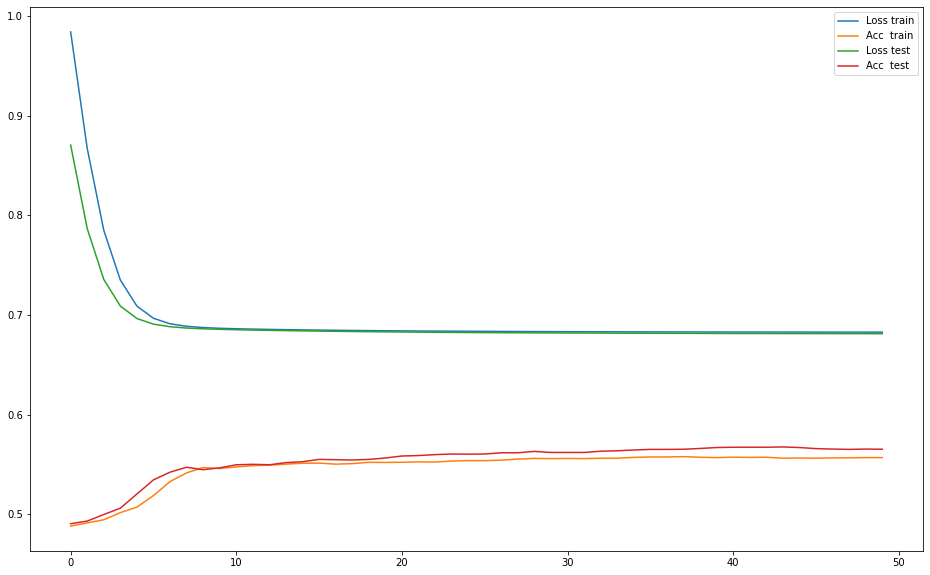

In [12]:
fig = plt.figure(figsize=(16,10))
plt.plot(ltr_curve, label="Loss train")
plt.plot(atr_curve, label="Acc  train")
plt.plot(lts_curve, label="Loss test")
plt.plot(ats_curve, label="Acc  test")
plt.legend()
plt.show()

In [13]:
coef = [p.cpu().detach().numpy() for p in model.parameters()]

Compare to LDA

In [14]:
model = LDA()
model.fit(X_train, y_train)
model.score(X_train, y_train)
model.score(X_test, y_test)

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5978093181116939

In [15]:
print(coef[0])
print(model.coef_)

[[ 0.00524781 -0.07989655  0.12800676 -0.03029741]]
[[ 0.02038725 -0.04903125  0.10061257  5.53390321]]


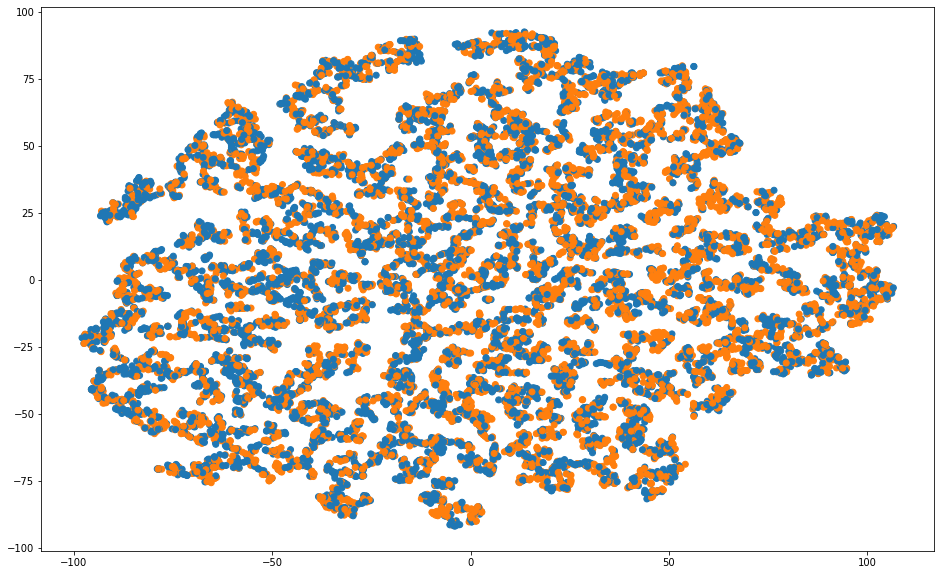

In [16]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_train.to_numpy())
fig = plt.figure(figsize=(16,10))
cmap = plt.cm.get_cmap('tab10')
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=cmap(y_train.to_numpy().astype(int)))

In [17]:
X_tr = (X_train.to_numpy() + coef[1]) * coef[0]
print(X_tr)

[[-0.03948616  0.11513617  0.21310582  0.14966328]
 [ 0.00707873  0.7363558  -0.08343147  0.14560787]
 [-0.0332534   0.12860584  0.3503734   0.1502719 ]
 ...
 [ 0.00091026  0.34036656 -0.20639425  0.14811538]
 [-0.03440128 -0.01012994  0.34245147  0.14880817]
 [-0.03186425  0.66216577 -0.0246981   0.14633936]]


In [18]:
Y_tr = y_train.to_numpy().astype(int)
print(Y_tr)

[[0]
 [1]
 [1]
 ...
 [0]
 [1]
 [1]]


In [19]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_tr)
print(X_embedded.shape)

(15122, 2)


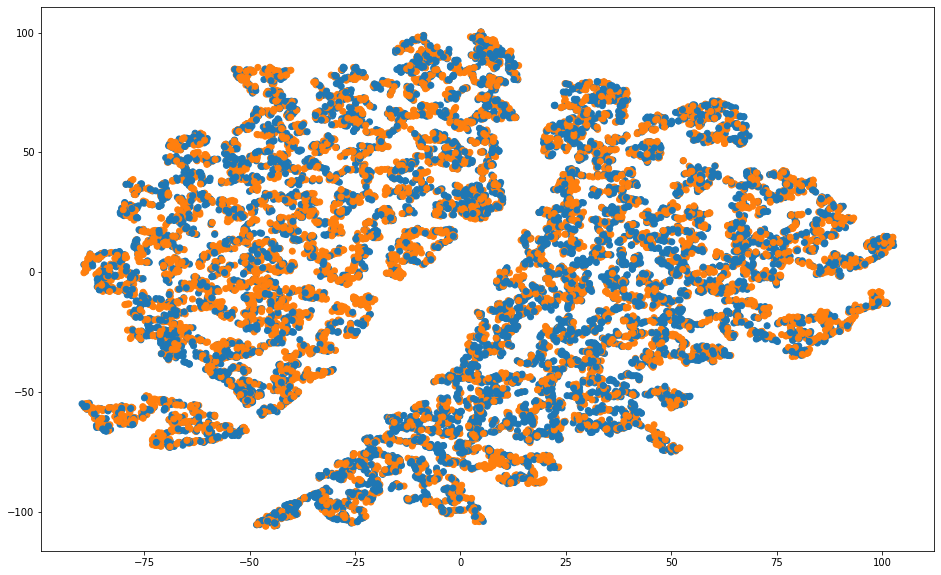

In [20]:
fig = plt.figure(figsize=(16,10))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=cmap(Y_tr))

In [21]:
X_tr = (X_train.to_numpy() + model.coef_)
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_tr)
print(X_embedded.shape)

(15122, 2)


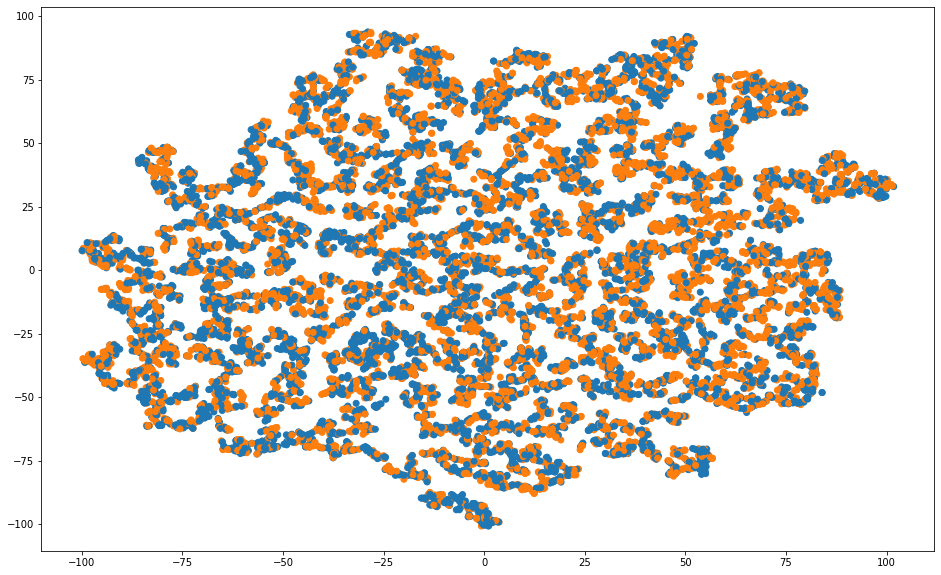

In [22]:
fig = plt.figure(figsize=(16,10))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=cmap(Y_tr))